In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

np.random.seed(20171001)
tf.set_random_seed(20171001)
mnist = input_data.read_data_sets("./data/", one_hot=True)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [2]:
cfilter_size = 16
input_size = 14*14*cfilter_size

with tf.name_scope('Input'):
    x = tf.placeholder(tf.float32, [None, 784])
    x_image = tf.reshape(x, [-1,28,28,1])
with tf.name_scope('Conv'):
    cfilter = tf.Variable(tf.truncated_normal([5,5,1,cfilter_size],stddev=0.1))
    cfiltered = tf.nn.conv2d(x_image, cfilter, strides=[1,1,1,1], padding='SAME')
with tf.name_scope('Pooling'):
    pfiltered = tf.nn.max_pool(cfiltered, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    pfiltered_flat = tf.reshape(pfiltered, [-1, input_size])

In [3]:
hidden_size = 1024

with tf.name_scope('Hidden'):
    w1 = tf.Variable(tf.truncated_normal([input_size, hidden_size]))
    b1 = tf.Variable(tf.zeros([hidden_size]))
    z = tf.nn.relu(tf.matmul(pfiltered_flat, w1) + b1)
with tf.name_scope('Output'):
    w0 = tf.Variable(tf.zeros([hidden_size, 10]))
    b0 = tf.Variable(tf.zeros([10]))
    p = tf.nn.softmax(tf.matmul(z, w0) + b0)

with tf.name_scope('T'):
    t = tf.placeholder(tf.float32, [None, 10])

In [4]:
with tf.name_scope('Loss'):
    loss = -tf.reduce_sum(t * tf.log(p))
with tf.name_scope('Train'):
    train_step = tf.train.AdamOptimizer().minimize(loss)
with tf.name_scope('Acc'):
    correct_prediction =  tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [5]:
sess = tf.InteractiveSession()
with tf.name_scope('summary'):
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('loss', loss)
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('./logs', sess.graph)

In [6]:
sess.run(tf.global_variables_initializer())
train_p = []
test_p = []
steps = []
i = 0
for _ in range(2000):
    batch_xs, batch_ts = mnist.train.next_batch(100)
    __, summary = sess.run([train_step, merged], feed_dict={x: batch_xs, t: batch_ts})
    
    if i % 100 == 0:
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict = {x: batch_xs, t: batch_ts})
        train_p.append(acc_val)
        test_p.append(sess.run(accuracy, feed_dict={x: mnist.test.images, t: mnist.test.labels}))
        steps.append(i/100)
        test_acc = sess.run(accuracy, feed_dict={x: mnist.test.images, t: mnist.test.labels})
        writer.add_summary(summary, _)
        print("step: %d, loss: %f, acc: %f, test: %f" % (i, loss_val, acc_val, test_acc))
    i += 1

step: 0, loss: 184.190430, acc: 0.400000, test: 0.200100
step: 100, loss: 22.369581, acc: 0.950000, test: 0.937300
step: 200, loss: 6.319028, acc: 0.980000, test: 0.956400
step: 300, loss: 18.047178, acc: 0.950000, test: 0.963100
step: 400, loss: 10.422319, acc: 0.980000, test: 0.965400
step: 500, loss: 7.943065, acc: 0.990000, test: 0.969600
step: 600, loss: 4.390870, acc: 0.990000, test: 0.971300
step: 700, loss: 4.522155, acc: 0.970000, test: 0.973800
step: 800, loss: 2.861604, acc: 0.990000, test: 0.974400
step: 900, loss: 3.363157, acc: 0.990000, test: 0.977300
step: 1000, loss: 5.544255, acc: 0.980000, test: 0.972100
step: 1100, loss: 6.916174, acc: 0.970000, test: 0.972000
step: 1200, loss: 2.125087, acc: 0.990000, test: 0.979600
step: 1300, loss: 0.972790, acc: 1.000000, test: 0.980200
step: 1400, loss: 1.404454, acc: 1.000000, test: 0.980500
step: 1500, loss: 1.012322, acc: 1.000000, test: 0.976300
step: 1600, loss: 9.178900, acc: 0.970000, test: 0.977600
step: 1700, loss: 1.0

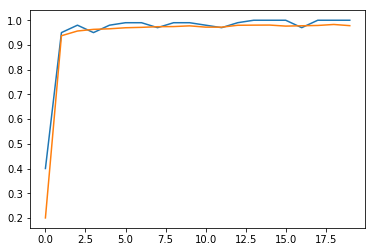

In [7]:
plt.plot(steps, train_p)
plt.plot(steps, test_p)

0.9


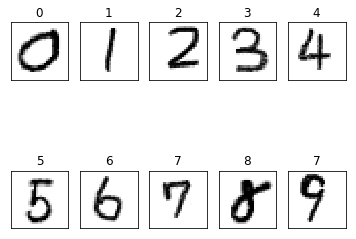

In [8]:
from PIL import Image
import os
filenames = os.listdir('./sample/test_samples')
c = 1
fig = plt.figure(figsize=(6, 5))
labels = []
imgs = []
for name in filenames:
    img = Image.open("./sample/test_samples/" + name).convert('L')
    img.thumbnail((28, 28))
    img = np.array(img, dtype=np.float32)
    img = 1-np.array(img / 255)
    img = img.reshape(1, 784)
    imgs.append(img)
    label = np.array([0,0,0,0,0,0,0,0,0,0])
    label[c-1] = 1
    labels.append(label)
    test_p = sess.run(p, feed_dict={x: img})
    subplot = fig.add_subplot(2, 5, c)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % (np.argmax(test_p)))
    subplot.imshow(img.reshape((28, 28)), vmin=0, vmax = 1, cmap=plt.cm.gray_r, interpolation="nearest")
    c += 1
print(sess.run(accuracy, feed_dict={x: np.array(imgs).reshape((10, 784)), t: labels}))

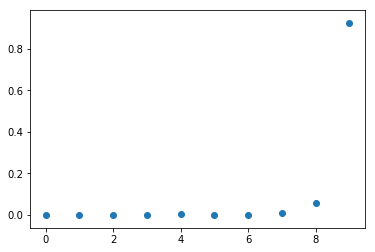

In [24]:
result_x = [0,1,2,3,4,5,6,7,8,9]
result_y = sess.run(p, feed_dict={x: np.array(imgs).reshape((10, 784)), t: labels})[9]
plt.scatter(result_x, result_y)

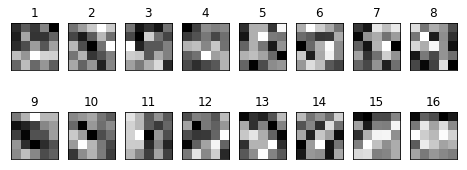

In [9]:
fil = sess.run(cfilter).reshape([5,5,16]).transpose([2,0,1])
c = 1
fig = plt.figure(figsize=(8, 3))
for f in fil:
    flatten_f = f.reshape([25, -1])
    flatten_f = flatten_f - flatten_f[np.argmin(f)]
    flatten_f = flatten_f / flatten_f[np.argmax(flatten_f)]
    test_p = sess.run(p, feed_dict={x: img})
    subplot = fig.add_subplot(2, 8, c)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % c)
    subplot.imshow(flatten_f.reshape((5, 5)), vmin=0, vmax = 1, cmap=plt.cm.gray_r, interpolation="nearest")
    c += 1

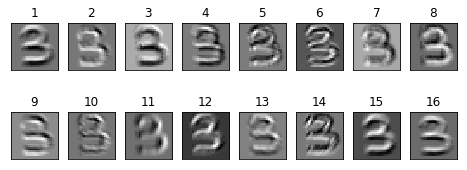

In [11]:
number = 3
filtered_img = sess.run(cfiltered, feed_dict={x: np.array([imgs[number]]).reshape((1, 784))}).reshape([28,28,16]).transpose([2,0,1])
c = 1
fig = plt.figure(figsize=(8, 3))
for f in filtered_img:
    flatten_f = f.reshape([784, -1])
    flatten_f = flatten_f - flatten_f[np.argmin(f)]
    flatten_f = flatten_f / flatten_f[np.argmax(flatten_f)]
    test_p = sess.run(p, feed_dict={x: img})
    subplot = fig.add_subplot(2, 8, c)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % c)
    subplot.imshow(flatten_f.reshape((28, 28)), vmin=0, vmax = 1, cmap=plt.cm.gray_r, interpolation="nearest")
    c += 1